In [2]:
%%capture
import plotly
import plotly.graph_objs as go
import cufflinks as cf

from collections import defaultdict
from kls import bdh
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
plotly.offline.init_notebook_mode(connected=True)
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem import  SnowballStemmer as stemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
import matplotlib as plt
%matplotlib inline 
from datetime import timedelta
import statsmodels.formula.api as smf


# Take aways: 
-	We are most likely to get a Trump tweet shock (China, Fed related) during 7am-10am. 
-	Trump is getting less popular among his supporters since the start of 2019, and pretty much like us, his supporters on twitters are tired of the trade war. 
-	Trump’s sentiment on China has been very volatile since end of July. Sentiment reached recent lows at the start of September, then sharply rebounded.
-	Trump’s twitter sentiment on China has been increasingly relevant to the market. The level of significance: FX > Rates > Equities. 
-	More specifically in FX, CNY, JPY, THB, CLP, AUD, COP, NZD are the most sensitive towards sentiment swings, while PHP IDR is the most immune from sentiment changes. 
-	Given the recent volatility in sentiment and record of trade negotiation, I think we are entering a short-term trade truce, but it doesn’t eliminate medium-term risks to trade and global growth. 

In [3]:
df = pd.read_csv('trumptwt.csv')
df= df[['date','username','tweet','mentions','likes_count','replies_count','time']].drop_duplicates('tweet')
df['date'] = pd.to_datetime(df['date'] )
df.set_index('date',inplace =True)
df= df.sort_index()

In [4]:
#######preprocess
#lemmatize + tokenize 
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
df['cleaned_tweet'] = df['tweet'].apply(lemmatize_text)

#remove stopwords later in tfidf
stopwords = nltk.corpus.stopwords.words('english')
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: [item for item in x if item not in stopwords])

df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : str(x).strip('[').strip(']'))

In [5]:
# df.reset_index().groupby('date')['tweet'].count().rolling(20).mean().iplot(title = 'Number of tweets by day')

# What time are we most vunerable to Trump twitter attack? 

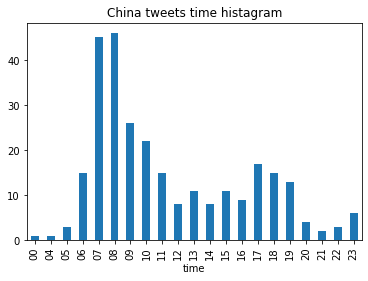

In [6]:
analyzer =  SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['compound']

df['time'] = df['time'].apply(lambda x: x.split(':')[0])
df['sentiment']=df['tweet'].apply(sentiment_analyzer_scores)
df['sentiment_rolling'] =df['sentiment'].rolling(20).mean()
china = df[df['tweet'].str.contains('China')]
fed = df[df['tweet'].str.contains('inflation')|df['tweet'].str.contains('Powell')|df['tweet'].str.contains('Fed ')|df['tweet'].str.contains('Powell')]
china.groupby('time')['tweet'].count().plot(kind = 'bar',title = 'China tweets time histagram')


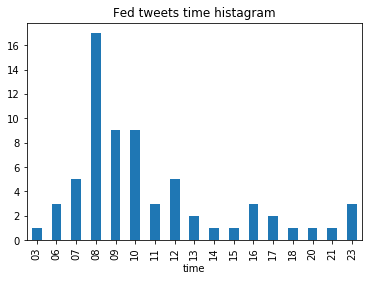

In [7]:
fed.groupby('time')['tweet'].count().plot(kind = 'bar',title = 'Fed tweets time histagram')

# Is Trump really getting less popular among his supporters? 

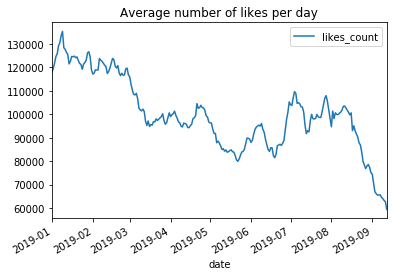

In [8]:

likes = df[['likes_count']].resample('D').mean()
likes[likes['likes_count']<=250000].rolling(15).mean().loc['2019-01-01':].plot(title = 'Average number of likes per day')

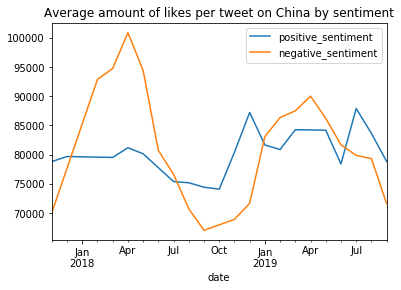

In [9]:
pos_likes = pd.DataFrame(china[china['sentiment_rolling']>= 0.25 ]['likes_count'].rolling(20).mean().interpolate())#.plot(label = 'positive tweets')
neg_likes = pd.DataFrame(china[china['sentiment_rolling']< 0.25 ]['likes_count'].rolling(20).mean().interpolate())#.plot(label = 'negative tweets')
pos_likes.columns = ['positive_sentiment']
neg_likes.columns = ['negative_sentiment']
neg_likes = neg_likes.resample('M').mean().interpolate()#.loc['2019-01-01':]
pos_likes = pos_likes.resample('M').mean().interpolate()#.loc['2019-01-01':]
# (neg_likes['negative_sentiment']) = [94216,
#  93987,
#  92932.55500000001,
#  93187.67333333334,
#  93442.79166666667,
#  91578.14375,
#  86211.98854166667,
#  80845.83333333333,
#  78054.63] 
pos_likes.join(neg_likes).dropna().plot(title = 'Average amount of likes per tweet on China by sentiment')

# What is Trump current stance on China? 

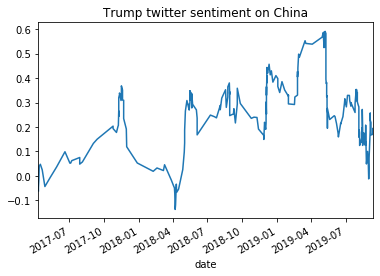

In [10]:
china['sentiment_rolling'] = china['sentiment'].rolling(20).mean().interpolate()
china['sentiment_rolling'].dropna().plot(title = 'Trump twitter sentiment on China')

# What about the market? 

In [12]:
instkr= { #STOCKS 
        'SPX':'SPX Index', 'SHCOMP':'SHCOMP Index', 'STOXX':'SXXP Index',
          #CCY
         'USDCNY':'USDCNY Curncy', 'USDJPY':'USDJPY Curncy',
        'THBCNY':'THBCNY Curncy', 
          #BONDS
        'US10Y':'USGG10YR Index', 'US2Y':'USGG2YR Index', 'GER2Y':'GTDEM2Y Govt', 'GER10Y':'GTDEM10Y Govt', 
    'USDJPY3MVOL':'USDJPYV3M Curncy','USDCNY3MVOL':'USDCNYV3M Curncy'
        }
intdict = {k:bdh(instkr[k],'PX_LAST','19900101','20200101' )for k in instkr.keys()}

In [13]:
intdf = pd.concat(intdict, axis = 1 )
intdf.columns = intdf.columns.droplevel(level=1)
#intdf = intdf.loc['2019-01-01':]

In [14]:
intdf = intdf.join(china)
intdf = intdf.interpolate()

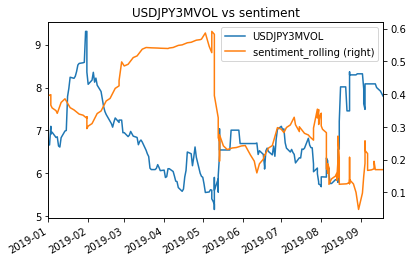

In [15]:
usdjpy = intdf[['USDJPY3MVOL','sentiment_rolling']]
usdjpy['USDJPY3MVOL'] = usdjpy['USDJPY3MVOL'].shift(20)
usdjpy.loc['2019-01-01':].interpolate().plot(secondary_y = 'sentiment_rolling', title = 'USDJPY3MVOL vs sentiment')

In [16]:
corrdf = pd.DataFrame()
test1 = intdf.loc['2019-01-01':]
for i in instkr.keys():
    corrdf[i] = [test1['sentiment_rolling'].corr(test1[i])]

In [17]:
reg_result= pd.DataFrame()
for i in intdf[list(intdict.keys())]: 
    test = intdf[[i, 'sentiment_rolling']].loc['2019-01-01':]
    lm1 = smf.ols(i+' ~ sentiment_rolling' , data=test.replace ([np.inf, -np.inf], np.nan).loc['2019-01-01':].dropna())
    # Fit the model
    fit1 = lm1.fit()
   # print( fit1.summary() )
    reg_result.loc[i, 'r2'] = fit1.rsquared
    reg_result.loc[i, 'coef']  = fit1.params[1]

In [20]:
reg_result.sort_values(by = 'r2', ascending = False)

,r2,coef
USDCNY,0.700711,-0.798430
THBCNY,0.691896,-0.042662
USDJPY,0.689230,10.695545
GER2Y,0.586499,0.641060
US10Y,0.545129,2.085570
US2Y,0.540283,1.871733
GER10Y,0.504888,1.457333
USDJPY3MVOL,0.306999,-3.315580
USDCNY3MVOL,0.286647,-2.539899
SHCOMP,0.107745,382.050523


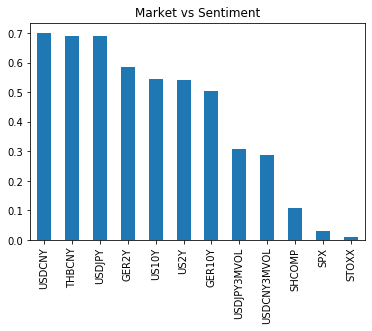

In [18]:
reg_result.sort_values(by = 'r2', ascending = False)['r2'].plot(kind = 'bar', title = 'Market vs Sentiment')

# Closer look at ccy performance in 2019

In [21]:
instkr= { #EM Asia
         'USDCNY':'USDCNY Curncy', 'USDTHB':'USDTHB Curncy','USDPHP':'USDPHP Curncy','USDINR':'USDINR Curncy','USDIDR':'USDIDR Curncy',
         #EM LatAm
         'USDBRL':'USDBRL Curncy','USDCLP':'USDCLP Curncy','USDMXN':'USDMXN Curncy','USDCOP':'USDCOP Curncy',
         #EM EE
         'USDCZK':'USDCZK Curncy','USDHUF':'USDHUF Curncy','USDPLN':'USDPLN Curncy',
         #DM
         'USDJPY':'USDJPY Curncy','USDEUR':'USDEUR Curncy','USDNOK':'USDNOK Curncy', 'USDAUD':'USDAUD Curncy','USDNZD':'USDNZD Curncy',
         'USDKRW':'USDKRW Curncy'
        
         
        }
intdict = {k:bdh(instkr[k],'PX_LAST','19900101','20200101' )for k in instkr.keys()}

In [22]:
intdf = pd.concat(intdict, axis = 1 )
intdf.columns = intdf.columns.droplevel(level=1)
#intdf = intdf.loc['2019-01-01':]
intdf = intdf.join(china[['sentiment_rolling']])
intdf = intdf.interpolate()

In [23]:
corr = intdf.loc['2019-01-01':].corr()

In [24]:
corr = corr.sort_values(by = 'sentiment_rolling')

In [25]:
corr = corr[['sentiment_rolling','USDAUD', 'USDBRL', 'USDCLP', 'USDCNY', 'USDCOP', 'USDCZK', 'USDEUR',
       'USDHUF', 'USDIDR', 'USDINR', 'USDJPY', 'USDMXN', 'USDNOK', 'USDNZD',
       'USDPHP', 'USDPLN', 'USDTHB']]

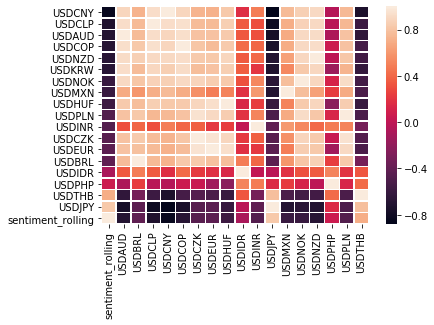

In [30]:
import seaborn as sns
sns.heatmap(corr, linewidth=0.5)

<img src="batman.jpg">